Found 10 slice files
Attribution_Patching_Binned_slice10of10_mlp.csv
Attribution_Patching_Binned_slice1of10_mlp.csv
Attribution_Patching_Binned_slice2of10_mlp.csv
Attribution_Patching_Binned_slice3of10_mlp.csv
Attribution_Patching_Binned_slice4of10_mlp.csv
Attribution_Patching_Binned_slice5of10_mlp.csv
Attribution_Patching_Binned_slice6of10_mlp.csv
Attribution_Patching_Binned_slice7of10_mlp.csv
Attribution_Patching_Binned_slice8of10_mlp.csv
Attribution_Patching_Binned_slice9of10_mlp.csv
Combined shape: (339416, 9)


/tmp/ipykernel_551807/3316338188.py:94: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im = plt.imshow(
/tmp/ipykernel_551807/3316338188.py:94: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im = plt.imshow(


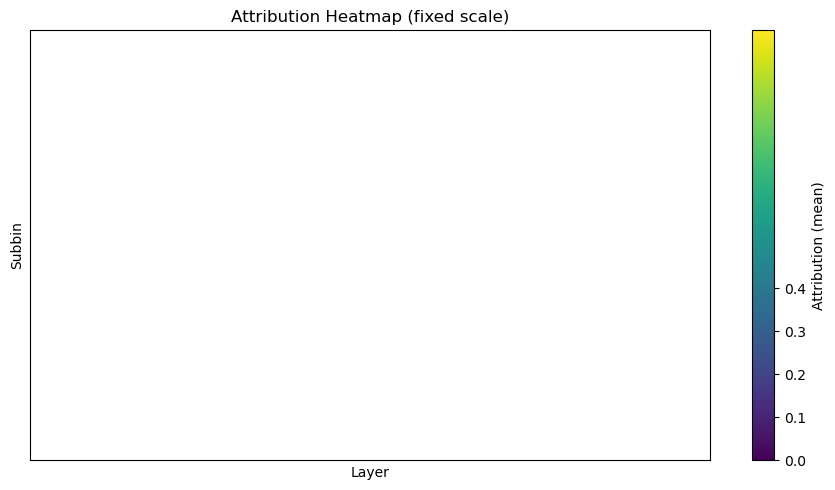

In [1]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np

BASE = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Attr_Results"
PATTERN = os.path.join(BASE, "Attribution_Patching_Binned_slice*of10_mlp.csv")

# Find all 10 slice files
files = sorted(glob.glob(PATTERN))

print(f"Found {len(files)} slice files")
for f in files:
    print(os.path.basename(f))

# Load + concatenate
df = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)

print("Combined shape:", df.shape)


FILTER_COMPONENT = None              # "mlp" or "attn" or None
FILTER_GROUP     = "VisCorrect_TextWrong"#"VisCorrect_TextWrong" or "Others"
FILTER_CATEGORY  = None

if FILTER_COMPONENT is not None:
    df = df[df["Component"] == FILTER_COMPONENT]
if FILTER_GROUP is not None:
    df = df[df["Group"] == FILTER_GROUP]
if FILTER_CATEGORY is not None:
    df = df[df["Category"] == FILTER_CATEGORY]

# -----------------------
# Parse Subbin -> (Bin, subidx, nsub) with backward compatibility
# Supports: Context_0/5, Entity_3/10, Query_4/5, Last_token_0/1, Final_0/1
# -----------------------
pat = re.compile(r"^(Context|Entity|Query|Last_token|Final)_(\d+)\/(\d+)$")

def parse_subbin(s):
    m = pat.match(str(s))
    if not m:
        return ("Other", 0, 1)
    return (m.group(1), int(m.group(2)), int(m.group(3)))

parsed = df["Subbin"].apply(parse_subbin)
df["BinParsed"] = parsed.apply(lambda x: x[0])
df["SubIdx"]    = parsed.apply(lambda x: x[1])
df["NSub"]      = parsed.apply(lambda x: x[2])

# Drop junk bins if any slipped in
df = df[df["BinParsed"].isin(["Context","Entity","Query","Last_token","Final"])].copy()

# -----------------------
# Aggregate: mean attribution per (subbin, layer)
# -----------------------
agg = (
    df.groupby(["BinParsed", "NSub", "SubIdx", "Layer"], as_index=False)["Attribution"]
      .mean()
)

# Define row order
bin_order = {"Context": 0, "Entity": 1, "Query": 2, "Last_token": 3, "Final": 4}
agg["BinOrder"] = agg["BinParsed"].map(bin_order)

# Build ordered row index
rows = (
    agg[["BinParsed", "NSub", "SubIdx", "BinOrder"]]
    .drop_duplicates()
    .sort_values(["BinOrder", "SubIdx"])
)

row_index = rows.set_index(["BinParsed","NSub","SubIdx"]).index
row_labels = [f"{b}_{i}/{n}" for (b,n,i) in row_index]

# Pivot to matrix: rows=subbins, cols=layers
mat = agg.pivot_table(
    index=["BinParsed", "NSub", "SubIdx"],
    columns="Layer",
    values="Attribution",
    fill_value=0.0
).reindex(row_index)

A = mat.to_numpy()
layers = mat.columns.to_numpy()

# -----------------------
# Plot with fixed color scale
# -----------------------


plt.figure(figsize=(9, 5))
im = plt.imshow(
    A,
    aspect="auto",
    origin="upper",
    interpolation="nearest"
)

plt.xlabel("Layer")
plt.ylabel("Subbin")
plt.title("Attribution Heatmap (fixed scale)")

# x ticks: show a few layers
xticks = np.linspace(0, len(layers)-1, num=min(8, len(layers)), dtype=int)
plt.xticks(xticks, layers[xticks])

# y ticks: show all (or comment out for cleaner look)
plt.yticks(np.arange(len(row_labels)), row_labels, fontsize=8)

# Optional: draw horizontal separators between bins
# (makes the figure much easier to read)
bin_starts = rows.groupby("BinParsed").head(1).index
# Convert those starts into row positions
start_rows = []
for b in ["Context","Entity","Query","Last_token","Final"]:
    idxs = np.where(rows["BinParsed"].to_numpy() == b)[0]
    if len(idxs):
        start_rows.append(int(idxs.min()))
for r in start_rows[1:]:
    plt.axhline(r - 0.5, linewidth=1.0)

cbar = plt.colorbar(im)
cbar.set_label("Attribution (mean)")
cbar.set_ticks([0.0, 0.1, 0.2, 0.3, 0.4])

plt.tight_layout()
plt.show()


Found 10 slice files
MLP: Vis_same_txt (Context) -> Diff: 0.5056 (High: 0.9569, 2nd: 0.4514)
MLP: Vis_diff_txt (Parametric) -> Diff: 0.0878 (High: 0.2282, 2nd: 0.1404)


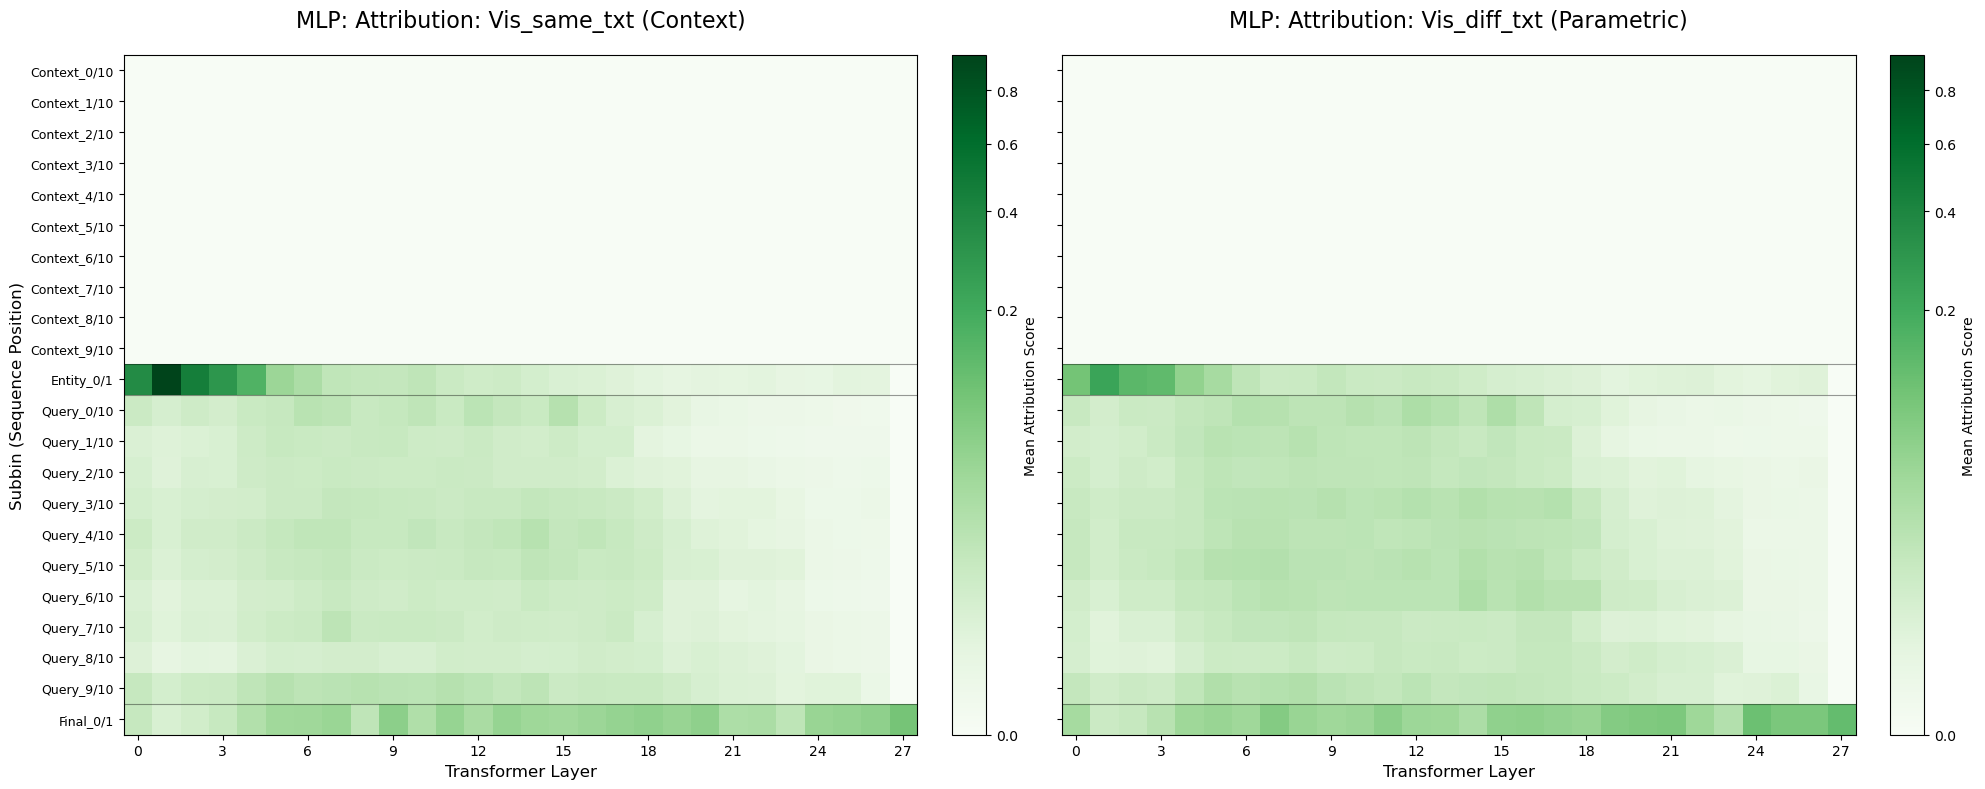

In [52]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
import numpy as np

# --- 1. Data Loading ---
BASE = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Attr_Results"
PATTERN = os.path.join(BASE, "Attribution_Patching_Binned_slice*of10_mlp.csv")

files = sorted(glob.glob(PATTERN))
print(f"Found {len(files)} slice files")
df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df_all = df_all[df_all['Category'] == 'Career_error']
def process_attribution_data(df_group):
    """Parses and aggregates attribution scores for a specific group."""
    pat = re.compile(r"^(Context|Entity|Query|Last_token|Final)_(\d+)\/(\d+)$")

    def parse_subbin(s):
        m = pat.match(str(s))
        if not m: return ("Other", 0, 1)
        return (m.group(1), int(m.group(2)), int(m.group(3)))

    parsed = df_group["Subbin"].apply(parse_subbin)
    df_group = df_group.copy()
    df_group["BinParsed"] = parsed.apply(lambda x: x[0])
    df_group["SubIdx"]    = parsed.apply(lambda x: x[1])
    df_group["NSub"]      = parsed.apply(lambda x: x[2])
    df_group = df_group[df_group["BinParsed"].isin(["Context","Entity","Query","Last_token","Final"])].copy()

    agg = df_group.groupby(["BinParsed", "NSub", "SubIdx", "Layer"], as_index=False)["Attribution"].mean()
    bin_order = {"Context": 0, "Entity": 1, "Query": 2, "Last_token": 3, "Final": 4}
    agg["BinOrder"] = agg["BinParsed"].map(bin_order)

    rows_info = agg[["BinParsed", "NSub", "SubIdx", "BinOrder"]].drop_duplicates().sort_values(["BinOrder", "SubIdx"])
    row_index = rows_info.set_index(["BinParsed","NSub","SubIdx"]).index
    row_labels = [f"{b}_{i}/{n}" for (b,n,i) in row_index]

    mat = agg.pivot_table(
        index=["BinParsed", "NSub", "SubIdx"],
        columns="Layer",
        values="Attribution",
        fill_value=0.0
    ).reindex(row_index)
    
    return mat, row_labels, rows_info

# --- 2. Filter Groups ---
#df_vis_correct = df_all[(df_all["Group"] == "VisParam_TextCont") | (df_all["Group"] == "VisTxtParam")]
#df_others = df_all[(df_all["Group"] == "VisTxtCont") | (df_all["Group"] == "VisCont_TextParam")]
df_vis_correct = df_all[(df_all["Group"] == "VisParam_TextCont")]
df_others = df_all[(df_all["Group"] == "VisTxtCont")]

mat_vis, labels_vis, info_vis = process_attribution_data(df_vis_correct)
mat_others, labels_others, info_others = process_attribution_data(df_others)


# --- 3. Side-by-Side Plotting with GLOBAL Scale ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
cmap = "Greens" 

# 1. Calculate the global maximum across both matrices to unify the scale
global_vmax = max(mat_others.max().max(), mat_vis.max().max())

for ax, mat, labels, info, title in zip(
    axes, 
    [mat_others, mat_vis], 
    [labels_others, labels_vis], 
    [info_others, info_vis], 
    ["Vis_same_txt (Context)", "Vis_diff_txt (Parametric)"]
):
    A = mat.to_numpy()
    layers = mat.columns.to_numpy()
    
    # 2. Use global_vmax here for both subplots
    #im = ax.imshow(A, aspect="auto", origin="upper", interpolation="nearest", 
    #               cmap=cmap, vmin=0, vmax=global_vmax)
    #POWER NORM SCALE#######
    gamma = 0.3   # try 0.3–0.6

    im = ax.imshow(
        A,
        aspect="auto",
        origin="upper",
        interpolation="nearest",
        cmap=cmap,
        norm=PowerNorm(gamma=gamma, vmin=0, vmax=global_vmax)
    )
    ###################
    
    ax.set_title(f"MLP: Attribution: {title}", fontsize=16, pad=20)
    ax.set_xlabel("Transformer Layer", fontsize=12)
    
    # Configure Ticks
    xticks = np.linspace(0, len(layers)-1, num=min(10, len(layers)), dtype=int)
    ax.set_xticks(xticks)
    ax.set_xticklabels(layers[xticks])
    
    if ax == axes[0]:
        ax.set_yticks(np.arange(len(labels)))
        ax.set_yticklabels(labels, fontsize=9)
        ax.set_ylabel("Subbin (Sequence Position)", fontsize=12)
    
    # Visual Separators for Bins
    start_rows = []
    for b in ["Context","Entity","Query","Last_token","Final"]:
        idxs = np.where(info["BinParsed"].to_numpy() == b)[0]
        if len(idxs):
            start_rows.append(int(idxs.min()))
    for r in start_rows[1:]:
        ax.axhline(r - 0.5, color="black", linewidth=0.8, alpha=0.4)

    # Add individual colorbar (they will now look identical in range)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Mean Attribution Score")

plt.tight_layout()
def get_top_two_analysis(mat, group_name):
    # Flatten all attribution scores in the matrix
    values = mat.to_numpy().flatten()
    # Get unique values sorted in descending order
    unique_sorted = np.sort(np.unique(values))[::-1]
    
    if len(unique_sorted) < 2:
        return f"{group_name}: Not enough unique values to compare."
    
    highest = unique_sorted[0]
    second_highest = unique_sorted[1]
    diff = highest - second_highest
    
    return {
        "Group": group_name,
        "Highest": highest,
        "Second": second_highest,
        "Difference": diff
    }

# For the MLP matrices
mlp_same_stats = get_top_two_analysis(mat_others, "MLP: Vis_same_txt (Context)")
mlp_diff_stats = get_top_two_analysis(mat_vis, "MLP: Vis_diff_txt (Parametric)")

print(f"{mlp_same_stats['Group']} -> Diff: {mlp_same_stats['Difference']:.4f} (High: {mlp_same_stats['Highest']:.4f}, 2nd: {mlp_same_stats['Second']:.4f})")
print(f"{mlp_diff_stats['Group']} -> Diff: {mlp_diff_stats['Difference']:.4f} (High: {mlp_diff_stats['Highest']:.4f}, 2nd: {mlp_diff_stats['Second']:.4f})")

In [ ]:
def count_points_per_cell(df_group):
    pat = re.compile(r"^(Context|Entity|Query|Last_token|Final)_(\d+)\/(\d+)$")

    def parse_subbin(s):
        m = pat.match(str(s))
        if not m:
            return ("Other", 0, 1)
        return (m.group(1), int(m.group(2)), int(m.group(3)))

    parsed = df_group["Subbin"].apply(parse_subbin)

    df_group = df_group.copy()
    df_group["BinParsed"] = parsed.apply(lambda x: x[0])
    df_group["SubIdx"]    = parsed.apply(lambda x: x[1])
    df_group["NSub"]      = parsed.apply(lambda x: x[2])

    df_group = df_group[df_group["BinParsed"].isin(
        ["Context","Entity","Query","Last_token","Final"]
    )]

    counts = (
        df_group
        .groupby(["Group", "BinParsed", "NSub", "SubIdx", "Layer"])
        .size()
        .rename("N_points")
        .reset_index()
    )

    return counts
BASE = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Attr_Results"
PATTERN = os.path.join(BASE, "Attribution_Patching_Binned_slice*of10_mlp.csv")

files = sorted(glob.glob(PATTERN))
print(f"Found {len(files)} slice files")
df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df_all = df_all[df_all['Category'] == 'Career_error']
counts_df = count_points_per_cell(df_all)
counts_df[counts_df['Group'] == 'VisParam_TextCont']
counts_df[counts_df['Group'] == 'VisTxtCont']['N_points']
#counts_df['Group'].value_counts()

Found 10 slice files


,Group,BinParsed,NSub,SubIdx,Layer,N_points
1232,VisTxtCont,Context,10,0,0,62
1233,VisTxtCont,Context,10,0,1,62
1234,VisTxtCont,Context,10,0,2,62
1235,VisTxtCont,Context,10,0,3,62
1236,VisTxtCont,Context,10,0,4,62
...,...,...,...,...,...,...
1843,VisTxtCont,Query,10,9,23,62
1844,VisTxtCont,Query,10,9,24,62
1845,VisTxtCont,Query,10,9,25,62
1846,VisTxtCont,Query,10,9,26,62


Found 10 slice files
ATTN: Vis_same_txt (Context) -> Diff: 0.0475 (High: 0.1620, 2nd: 0.1145)
ATTN: Vis_diff_txt (Parametric) -> Diff: 0.0751 (High: 0.3008, 2nd: 0.2258)


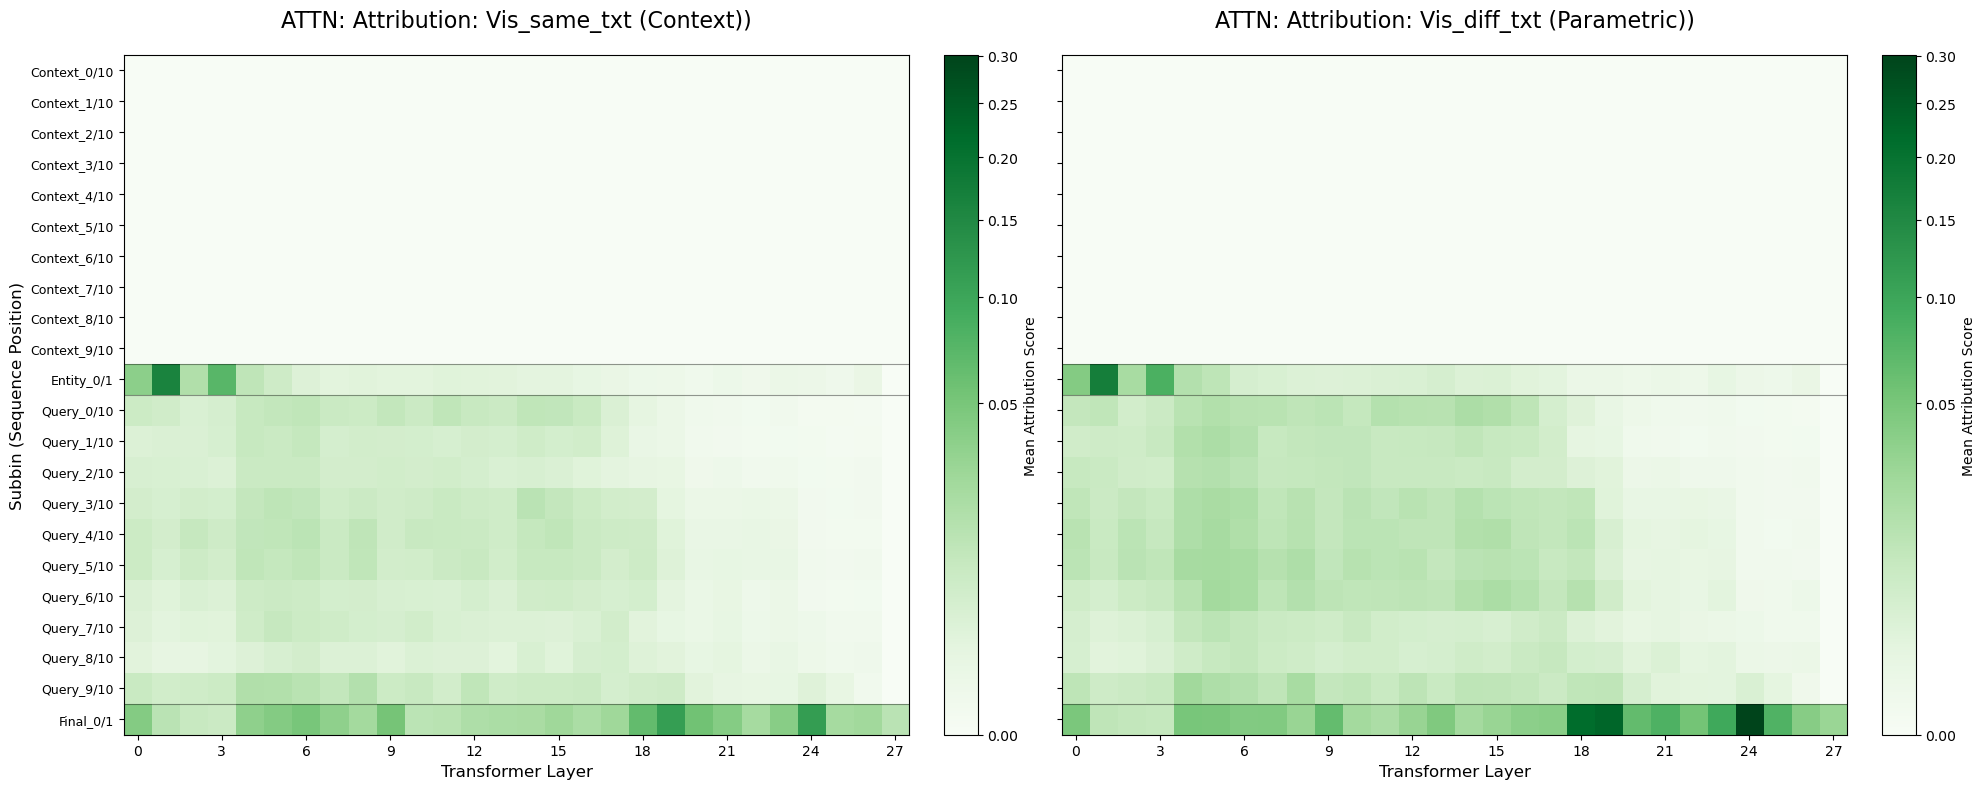

In [50]:
import pandas as pd
import glob
import os
import re
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Data Loading ---
BASE = "/users/aparasel/scratch/VvsLMem-Cntxt-Conflict/Scripts/Attr_Results"
PATTERN = os.path.join(BASE, "Attribution_Patching_Binned_slice*of10_attention.csv")

files = sorted(glob.glob(PATTERN))
print(f"Found {len(files)} slice files")
df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df_all = df_all[df_all['Category'] == 'Career_error']
def process_attribution_data(df_group):
    """Parses and aggregates attribution scores for a specific group."""
    pat = re.compile(r"^(Context|Entity|Query|Last_token|Final)_(\d+)\/(\d+)$")

    def parse_subbin(s):
        m = pat.match(str(s))
        if not m: return ("Other", 0, 1)
        return (m.group(1), int(m.group(2)), int(m.group(3)))

    parsed = df_group["Subbin"].apply(parse_subbin)
    df_group = df_group.copy()
    df_group["BinParsed"] = parsed.apply(lambda x: x[0])
    df_group["SubIdx"]    = parsed.apply(lambda x: x[1])
    df_group["NSub"]      = parsed.apply(lambda x: x[2])
    df_group = df_group[df_group["BinParsed"].isin(["Context","Entity","Query","Last_token","Final"])].copy()

    agg = df_group.groupby(["BinParsed", "NSub", "SubIdx", "Layer"], as_index=False)["Attribution"].mean()
    bin_order = {"Context": 0, "Entity": 1, "Query": 2, "Last_token": 3, "Final": 4}
    agg["BinOrder"] = agg["BinParsed"].map(bin_order)

    rows_info = agg[["BinParsed", "NSub", "SubIdx", "BinOrder"]].drop_duplicates().sort_values(["BinOrder", "SubIdx"])
    row_index = rows_info.set_index(["BinParsed","NSub","SubIdx"]).index
    row_labels = [f"{b}_{i}/{n}" for (b,n,i) in row_index]

    mat = agg.pivot_table(
        index=["BinParsed", "NSub", "SubIdx"],
        columns="Layer",
        values="Attribution",
        fill_value=0.0
    ).reindex(row_index)
    
    return mat, row_labels, rows_info

# --- 2. Filter Groups ---
#df_vis_correct = df_all[df_all["Group"] == "VisParam_TextCont"]
#df_others = df_all[df_all["Group"] == "VisTxtCont"]
df_vis_correct = df_all[(df_all["Group"] == "VisParam_TextCont")]
df_others = df_all[(df_all["Group"] == "VisTxtCont")]


mat_vis, labels_vis, info_vis = process_attribution_data(df_vis_correct)
mat_others, labels_others, info_others = process_attribution_data(df_others)


# --- 3. Side-by-Side Plotting with GLOBAL Scale ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
cmap = "Greens" 

# 1. Calculate the global maximum across both matrices to unify the scale
global_vmax = max(mat_others.max().max(), mat_vis.max().max())

for ax, mat, labels, info, title in zip(
    axes, 
    [mat_others, mat_vis], 
    [labels_others, labels_vis], 
    [info_others, info_vis], 
    ["Vis_same_txt (Context)", "Vis_diff_txt (Parametric)"]
):
    A = mat.to_numpy()
    layers = mat.columns.to_numpy()
    
    # 2. Use global_vmax here for both subplots
    #im = ax.imshow(A, aspect="auto", origin="upper", interpolation="nearest", 
    #               cmap=cmap, vmin=0, vmax=global_vmax)
    
    gamma = 0.4   # try 0.3–0.6

    im = ax.imshow(
        A,
        aspect="auto",
        origin="upper",
        interpolation="nearest",
        cmap=cmap,
        norm=PowerNorm(gamma=gamma, vmin=0, vmax=global_vmax)
    )
    ax.set_title(f"ATTN: Attribution: {title})", fontsize=16, pad=20)
    ax.set_xlabel("Transformer Layer", fontsize=12)
    
    # Configure Ticks
    xticks = np.linspace(0, len(layers)-1, num=min(10, len(layers)), dtype=int)
    ax.set_xticks(xticks)
    ax.set_xticklabels(layers[xticks])
    
    if ax == axes[0]:
        ax.set_yticks(np.arange(len(labels)))
        ax.set_yticklabels(labels, fontsize=9)
        ax.set_ylabel("Subbin (Sequence Position)", fontsize=12)
    
    # Visual Separators for Bins
    start_rows = []
    for b in ["Context","Entity","Query","Last_token","Final"]:
        idxs = np.where(info["BinParsed"].to_numpy() == b)[0]
        if len(idxs):
            start_rows.append(int(idxs.min()))
    for r in start_rows[1:]:
        ax.axhline(r - 0.5, color="black", linewidth=0.8, alpha=0.4)

    # Add individual colorbar (they will now look identical in range)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Mean Attribution Score")

plt.tight_layout()
def get_top_two_analysis(mat, group_name):
    # Flatten all attribution scores in the matrix
    values = mat.to_numpy().flatten()
    # Get unique values sorted in descending order
    unique_sorted = np.sort(np.unique(values))[::-1]
    
    if len(unique_sorted) < 2:
        return f"{group_name}: Not enough unique values to compare."
    
    highest = unique_sorted[0]
    second_highest = unique_sorted[1]
    diff = highest - second_highest
    
    return {
        "Group": group_name,
        "Highest": highest,
        "Second": second_highest,
        "Difference": diff
    }

# For the MLP matrices
mlp_same_stats = get_top_two_analysis(mat_others, "ATTN: Vis_same_txt (Context)")
mlp_diff_stats = get_top_two_analysis(mat_vis, "ATTN: Vis_diff_txt (Parametric)")

print(f"{mlp_same_stats['Group']} -> Diff: {mlp_same_stats['Difference']:.4f} (High: {mlp_same_stats['Highest']:.4f}, 2nd: {mlp_same_stats['Second']:.4f})")
print(f"{mlp_diff_stats['Group']} -> Diff: {mlp_diff_stats['Difference']:.4f} (High: {mlp_diff_stats['Highest']:.4f}, 2nd: {mlp_diff_stats['Second']:.4f})")

In [6]:
df_all['Group'].value_counts()

Group
VisTxtParam          91168
VisParam_TextCont    38808
VisTxtCont           38192
VisCont_TextParam      616
Name: count, dtype: int64

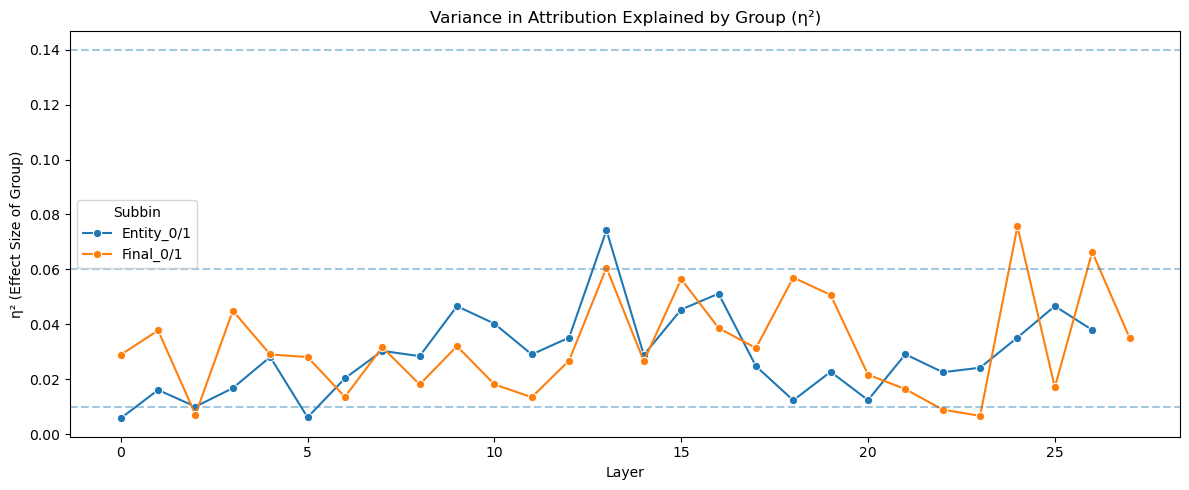

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def eta_squared_by_layer_subbin(df):
    results = []

    for (layer, subbin), g in df.groupby(["Layer", "Subbin"]):
        # overall mean
        grand_mean = g["Attribution"].mean()

        # total sum of squares
        ss_total = ((g["Attribution"] - grand_mean) ** 2).sum()

        # between-group sum of squares
        ss_between = (
            g.groupby("Group")["Attribution"]
            .apply(lambda x: len(x) * (x.mean() - grand_mean) ** 2)
            .sum()
        )

        eta2 = ss_between / ss_total if ss_total > 0 else np.nan

        results.append({
            "Layer": layer,
            "Subbin": subbin,
            "Eta2_Group": eta2
        })

    return pd.DataFrame(results)


eta_df = eta_squared_by_layer_subbin(
    df_all[df_all["Bin"].isin(["Entity", "Final"])]
)

eta_df.head()

plt.figure(figsize=(12, 5))

sns.lineplot(
    data=eta_df,
    x="Layer",
    y="Eta2_Group",
    hue="Subbin",
    marker="o"
)

plt.title("Variance in Attribution Explained by Group (η²)")
plt.ylabel("η² (Effect Size of Group)")
plt.xlabel("Layer")
plt.axhline(0.01, ls="--", alpha=0.4)  # small
plt.axhline(0.06, ls="--", alpha=0.4)  # medium
plt.axhline(0.14, ls="--", alpha=0.4)  # large
plt.tight_layout()
plt.show()


In [25]:
df[df['Bin'] == "Entity"].max()

ID                               14
Entity                    Tom Hanks
Category             location_error
Group          VisCorrect_TextWrong
Layer                            27
Component                       mlp
Bin                          Entity
Subbin                  Entity_9/10
Attribution                0.079041
dtype: object